**Instructions**

Run the notebook to see the LIME evaluation on the FELTD EB model, with the pre-loaded LIME object, or re-create the LIME object on a new model  

For full commented and referenced code on the model aspect, see the FELTD EB model notebook, only the LIME code is commented here  

Limited elements of the LIME code were adapted from: https://marcotcr.github.io/lime/tutorials/Lime%20-%20multiclass.html, where marked "(see ref above)" otherwise it is original

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from PIL import Image
import os
import re

In [3]:
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter
from torchtext.vocab import Vocab

In [4]:
from torchtext.vocab import Vocab
# %%capture
from tqdm.notebook import tqdm
tqdm().pandas()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [5]:
from F8_utils import *

In [6]:
df = pd.read_csv('text_emotion_cleaned.csv', dtype={'tweet_without_stopwords': str})
df['content']=df['tweet_without_stopwords'].astype('str')
df['label'] = pd.factorize(df['sentiment'])[0].astype(np.uint16)
df_train = df.iloc[:32000]
df_valid = df.iloc[32000:36000]
df_test = df.iloc[36000:40000]

In [7]:
class FigureEight(Dataset):  #with val
    
    def __init__(self, df):
        super().__init__()
        self.df=df

        self.classes = list(self.df['sentiment'].unique())
        self.sort_key=False
        self.fields = {'content':df['content'], 'label':df['label']}
                                                  
    def __len__(self):  
        return len(self.df)
                                            
    def __getitem__(self, idx):
        X = self.df['content'].iloc[idx]                        
        y = self.df['label'].iloc[idx]                                  

        return idx,X,y   

trainset=FigureEight(df_train)
# valset=FigureEight(df_valid)
#testset=FigureEight(df_test)

In [8]:
tokenizer = get_tokenizer('basic_english')
def yield_tokens(trainset):
    for i in range (len(trainset)):
        _, text, _ = trainset[i]
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(trainset), specials=["<unk>"], min_freq=2)
vocab.set_default_index(vocab["<unk>"])

In [9]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc1 = nn.Linear(embed_dim, 2*embed_dim)
        self.fc2 = nn.Linear(2*embed_dim, num_class)
        self.init_weights() 

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        x = torch.relu(self.fc1(embedded))
        return self.fc2(x) 
    
    def tokenizer(self, text):
        return make_shap_token_obj(text)

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (idx, text, label) in batch:
         label_list.append(label_pipeline(label))
         processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)    


def text_pipeline(X): 
        return [vocab[token] for token in tokenizer(X)]   

def text_pipeline_batch(text):
    return np.array([text_pipeline(x) for x in text])

num_class = len(df['label'].unique())
vocab_size = len(vocab)
emsize = 64
net = TextClassificationModel(vocab_size, emsize, num_class).to(device)
load_checkpoint('embed_bag_model_weights_FINAL.pth', net, device) # or load another trained model
net.to(device)
net.eval()

Model's pretrained weights loaded!


TextClassificationModel(
  (embedding): EmbeddingBag(10553, 64, mode=mean)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
)

**LIME Explanations**

In [10]:
#import lime
from lime import lime_text

In [11]:
#amend collate batch function from model so it works with LIME
def collate_explain_batch(batch):
    text_list, offsets = [], [0]
    for text in batch:
         processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return text_list.to(device), offsets.to(device)    

In [12]:
#define original prediction func so it works with LIME

def pred_func(text):
    x, offsets = collate_explain_batch(text)
    logits = net(x, offsets)
    y_pred = torch.softmax(logits,-1) # gives dimen to perform probs (which dimen sums to 1)
    return y_pred.detach().cpu().numpy()

In [13]:
#create explainer (see ref above)
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=trainset.classes)

In [14]:
#state classes
trainset.classes

['empty',
 'sadness',
 'enthusiasm',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief',
 'anger']

In [15]:
# concatenate all tweets into a single string
my_string = trainset[:][1].str.cat(sep=' ')

In [16]:
#define label indices
labels_inds = list(range(13))

In [17]:
#to load pre-created LIME object for the top 9 features
import pickle

with open('myLIMEobj', 'rb') as f:
     exp_all = pickle.load(f)

In [18]:
# #ALTERNATIVELY uncomment to create LIME explainer object from scratch
# # NB this will take approx 48 minutes on a fast machine
# %timeit
# exp_all = explainer.explain_instance(my_string, pred_func, num_features=9, labels=labels_inds) ##(see ref above)

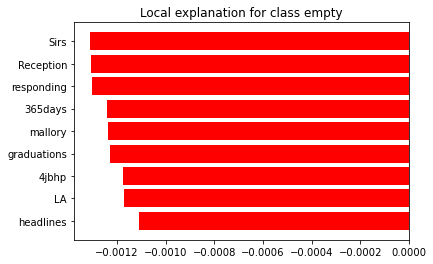

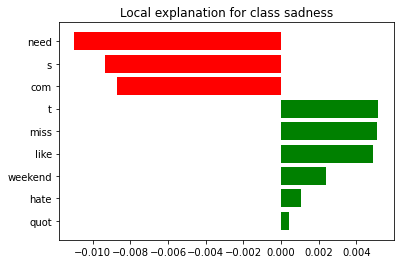

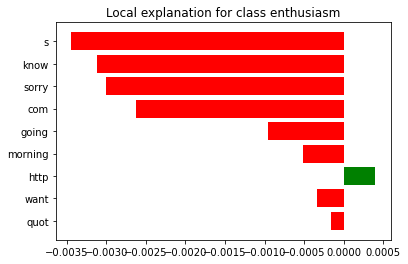

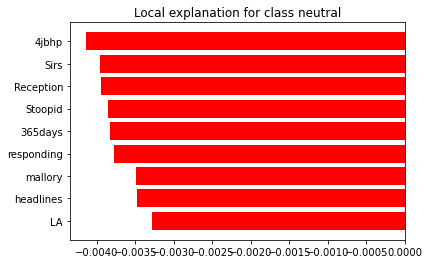

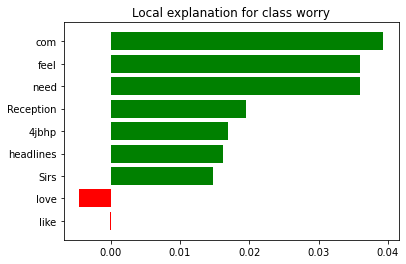

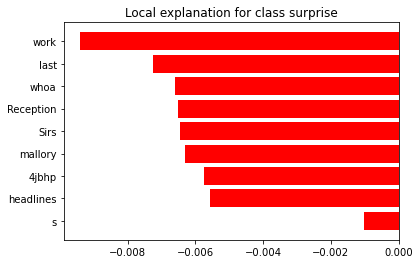

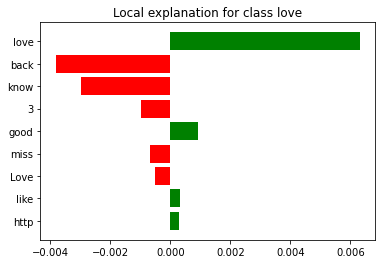

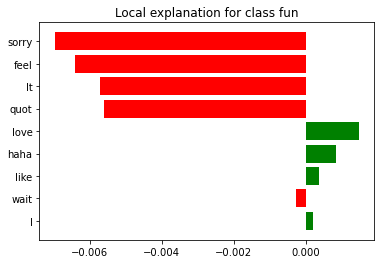

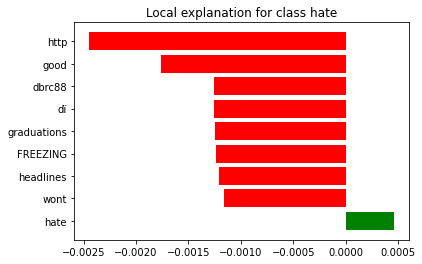

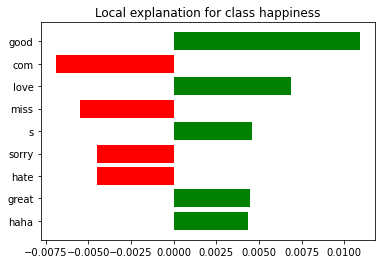

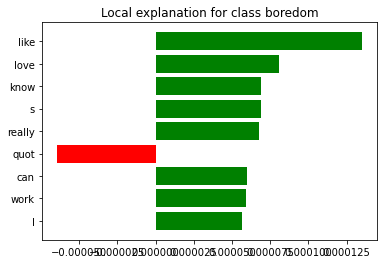

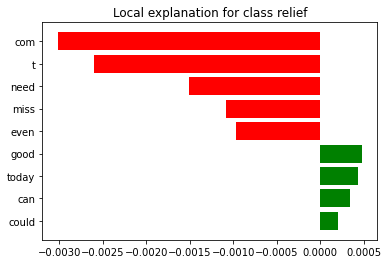

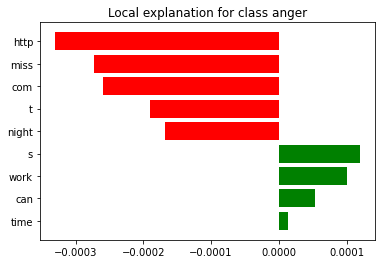

In [19]:
#display LIME explaination for all classes
for i in range(13):
    exp_all.as_pyplot_figure(label=i)

In [20]:
#pick single example tweet
trainset[8][1]

'Charlene love. miss'

In [21]:
#create LIME explanation on single tweet
single_str = trainset[8][1]
exp_single = explainer.explain_instance(single_str, pred_func, num_features=9, labels=labels_inds)

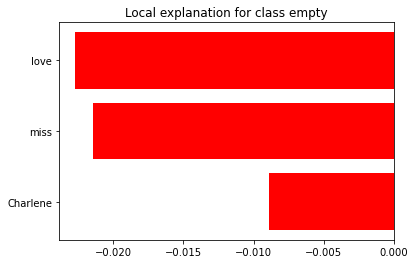

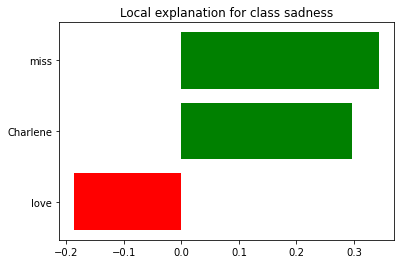

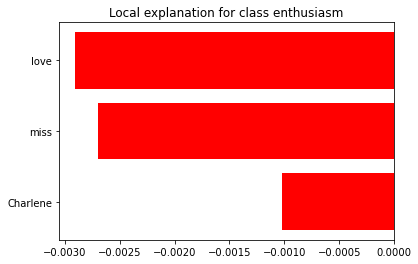

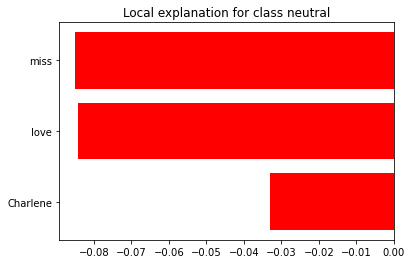

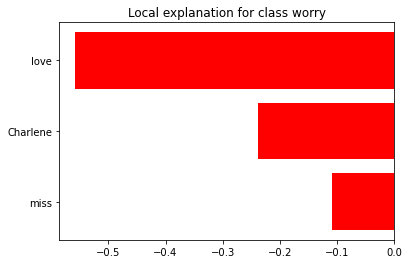

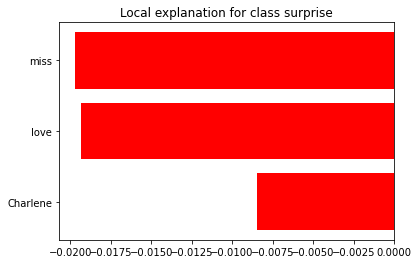

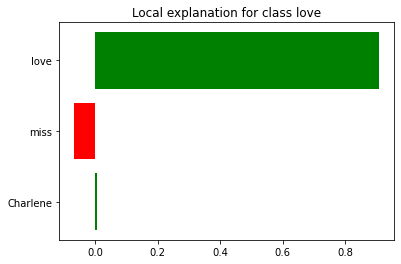

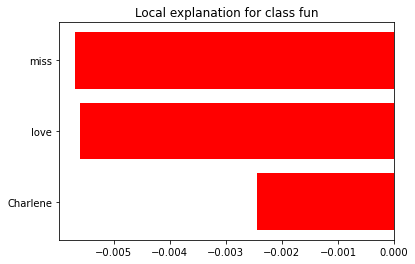

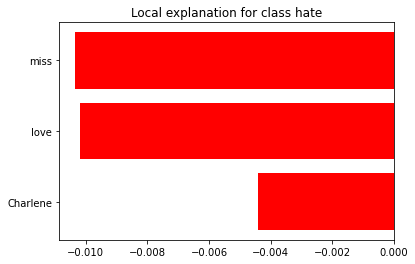

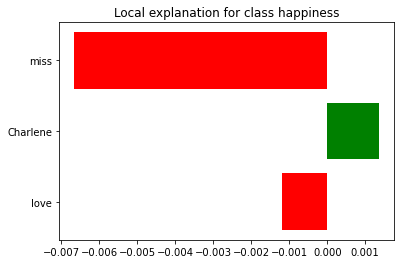

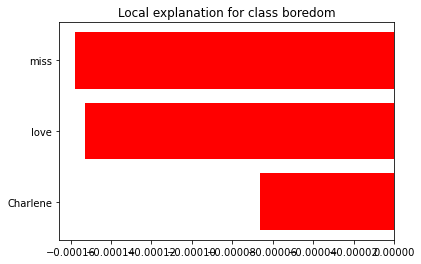

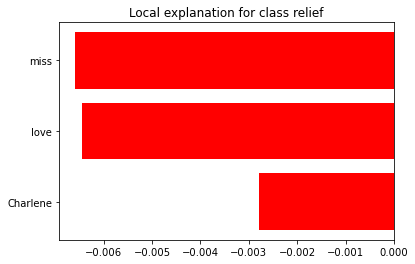

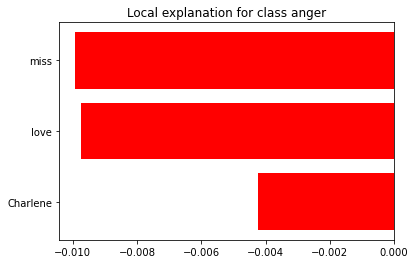

In [22]:
#show LIME explanation
for i in range(13):
    exp_single.as_pyplot_figure(label=i)